In this notebook we are going to be doing a small benchmark.

In [1]:
from skrub.datasets import fetch_employee_salaries
dataset = fetch_employee_salaries()
df = dataset.X

In [12]:
y = dataset.y
X = dataset.X["employee_position_title"]

In [2]:
df

,gender,department,department_name,division,assignment_category,employee_position_title,date_first_hired,year_first_hired
0,F,POL,Department of Police,MSB Information Mgmt and Tech Division Records...,Fulltime-Regular,Office Services Coordinator,09/22/1986,1986
1,M,POL,Department of Police,ISB Major Crimes Division Fugitive Section,Fulltime-Regular,Master Police Officer,09/12/1988,1988
2,F,HHS,Department of Health and Human Services,Adult Protective and Case Management Services,Fulltime-Regular,Social Worker IV,11/19/1989,1989
3,M,COR,Correction and Rehabilitation,PRRS Facility and Security,Fulltime-Regular,Resident Supervisor II,05/05/2014,2014
4,M,HCA,Department of Housing and Community Affairs,Affordable Housing Programs,Fulltime-Regular,Planning Specialist III,03/05/2007,2007
...,...,...,...,...,...,...,...,...
9223,F,HHS,Department of Health and Human Services,School Based Health Centers,Fulltime-Regular,Community Health Nurse II,11/03/2015,2015
9224,F,FRS,Fire and Rescue Services,Human Resources Division,Fulltime-Regular,Fire/Rescue Division Chief,11/28/1988,1988
9225,M,HHS,Department of Health and Human Services,Child and Adolescent Mental Health Clinic Serv...,Parttime-Regular,Medical Doctor IV - Psychiatrist,04/30/2001,2001
9226,M,CCL,County Council,Council Central Staff,Fulltime-Regular,Manager II,09/05/2006,2006


In a previous video I explained the idea behind the `GapEncoder`. There's some solid theory that went into that component, but we didn't run a proper benchmark with it. The goal of this video is to actually run a proper benchmark. 

We'll see that even for a relatively limited and straightforward benchmark ... there's a big story to unravel. 

## The Goal 

For this demo we will make a model to predict the salary based _purely_ on the `employee_position_title` column. We're keeping it simple but just this text column can be modelled in many ways. Sure, we can use the `GapEncoder` but there are many other ways to encode text. 

- We can use sentence encoding BERT models.
- We can use basic countvectors.
- We can use subword embeddings, I personally think the BytePair embeddings are a cool trick.
- We can use countvectors followed by `SVD`. This is similar to the `GapEncoder` in a few ways, mainly in the way that it's able to turn a sparse encoding into something dense, but it doesn't use the same priors.

So ... just as a start ... let's just try and compare these approaches! 

In [3]:
from embetter.text import SentenceEncoder, BytePairEncoder
from embetter.grab import ColumnGrabber
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

from skrub import GapEncoder


pipe_gap = make_pipeline(
    GapEncoder(n_components=10),
    LinearRegression()
)

pipe_svd = make_pipeline(
    ColumnGrabber("employee_position_title"),
    CountVectorizer(analyzer="char", ngram_range=(2,3)), 
    TruncatedSVD(n_components=10),
    LinearRegression()
)

pipe_cv = make_pipeline(
    ColumnGrabber("employee_position_title"),
    CountVectorizer(analyzer="char", ngram_range=(2,3)), 
    LinearRegression()
)

pipe_sbert = make_pipeline(
    ColumnGrabber("employee_position_title"),
    SentenceEncoder(),
    LinearRegression()
)

pipe_bp = make_pipeline(
    ColumnGrabber("employee_position_title"),
    BytePairEncoder("en", agg="both"),
    LinearRegression()
)

/Users/vincent/Development/benchy/venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/Users/vincent/Development/benchy/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
pipelines = {
    "pipe_gap": pipe_gap,
    "pipe_svd": pipe_svd,
    "pipe_sbert": pipe_sbert,
    "pipe_bp": pipe_bp,
    "pipe_cv": pipe_cv
}

def calc_score(name, pipeline, cv=5):
    scores = cross_val_score(pipeline, X, y, cv=cv)
    return [{"name": name, "score": score} for score in scores]

In [82]:
from math import sqrt
from joblib import Parallel, delayed

pool = Parallel(n_jobs=-1)
workload = [delayed(calc_score)(name , pipe) for name, pipe in pipelines.items()]
out = pool(workload)

Using TensorFlow backend
Using TensorFlow backend


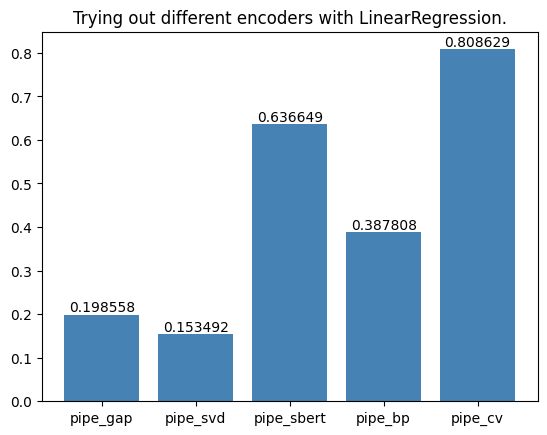

In [83]:
import numpy as np
from functools import reduce 
import pandas as pd 
import matplotlib.pylab as plt 


for i, batch in enumerate(out):
    scores = [_['score'] for _ in batch]
    b = plt.bar(batch[0]['name'], np.mean(scores), color="steelblue")
    plt.bar_label(b)
plt.title("Trying out different encoders with LinearRegression.");

Looking at these results, it seems like the `CountVectorizer` is doing a lot of good work here. The other approaches seem to fall short. 

But this isn't the time for conclusions just yet. Let's try to think about what this chart _isn't_ telling us. 

### Linear Regression 

Right now we're just feeding our results to a linear regression model. This is a nice base model ... but it comes with limits. Linear regression tends to work reasonable when the input revolves around one main cluster, but if the features that it receives are heavily clustered ... the linear regression has no way to split up and specialize for each of them. So maybe ... we gotta use a boosted tree here for fairness. 

In [84]:
pipe_gap = make_pipeline(
    GapEncoder(n_components=10),
    HistGradientBoostingRegressor()
)

pipe_svd = make_pipeline(
    ColumnGrabber("employee_position_title"),
    CountVectorizer(analyzer="char", ngram_range=(2,3)), 
    TruncatedSVD(n_components=10),
    HistGradientBoostingRegressor()
)

pipe_cv = make_pipeline(
    ColumnGrabber("employee_position_title"),
    CountVectorizer(analyzer="char", ngram_range=(2,3)), 
    LinearRegression()
)

pipe_sbert = make_pipeline(
    ColumnGrabber("employee_position_title"),
    SentenceEncoder(),
    HistGradientBoostingRegressor()
)

pipe_bp = make_pipeline(
    ColumnGrabber("employee_position_title"),
    BytePairEncoder("en", agg="both"),
    HistGradientBoostingRegressor()
)

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

In [85]:
pipelines_boosted = {
    "pipe_gap": pipe_gap,
    "pipe_svd": pipe_svd,
    "pipe_sbert": pipe_sbert,
    "pipe_bp": pipe_bp,
    "pipe_cv": pipe_cv
}

pool = Parallel(n_jobs=-1)
workload = [delayed(calc_score)(name , pipe) for name, pipe in pipelines_boosted.items()]
out_boosted = pool(workload)

Using TensorFlow backend
Using TensorFlow backend


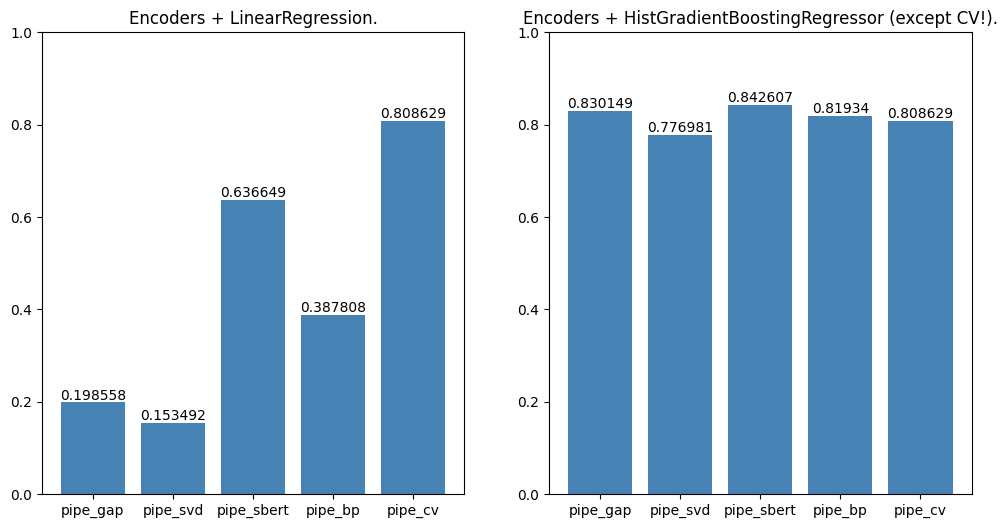

In [89]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
for i, batch in enumerate(out):
    scores = [_['score'] for _ in batch]
    b = plt.bar(batch[0]['name'], np.mean(scores), color="steelblue")
    plt.bar_label(b)
plt.ylim(0, 1)
plt.title("Encoders + LinearRegression.");

plt.subplot(1,2,2)
for i, batch in enumerate(out_boosted):
    scores = [_['score'] for _ in batch]
    b = plt.bar(batch[0]['name'], np.mean(scores), color="steelblue")
    plt.bar_label(b)
plt.ylim(0, 1)
plt.title("Encoders + HistGradientBoostingRegressor (except CV!).");

> Note that the CV output is sparse and the hist gradient model doesn't accept that. 

In [20]:
from sklearn.model_selection import GridSearchCV

pipe_gap = make_pipeline(
    GapEncoder(n_components=10),
    HistGradientBoostingRegressor(), 
    memory="gap"
)

cv = GridSearchCV(pipe_gap, {"gapencoder__n_components": [10, 20, 50, 100, 200, 500]}, refit=False, n_jobs=-1)
cv.fit(X, y)

GridSearchCV(estimator=Pipeline(memory='gap',
                                steps=[('gapencoder', GapEncoder()),
                                       ('histgradientboostingregressor',
                                        HistGradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'gapencoder__n_components': [10, 20, 50, 100, 200,
                                                      500]},
             refit=False)

In [29]:
cv.cv_results_["mean_test_score"].max()

0.8485564537127284